# Notebook D: Generate recommendations for Cycle 2 using ART 

This notebook uses the designs created by ART and the corresponding isoprenol production levels generated through OMG, to build a predictive model through ART. ART's model will be able to predict isoprenol production given the design as input. We will then use this model to recommend designs that optimize isoprenol production.

Tested using **ART_v3.6** kernel on jprime.lbl.gov 

## Inputs and Outputs

#### Required files to run this notebook:
- None, data will be automatically drawn from EDD

#### Files generated by running this notebook:

- `ART_training_EDDstyle.csv`, a file for ART front end import 
- Standard ART output files (containing recommendations, predictive accuracy metrics, plots of predictions vs observations for the train data set, pickle file containing previously trained ART object) in the corresponding directory.
- `ARTrecommendations.csv`, a file containing the ART recommendations


## Setup

In [1]:
from edd_utils import login, export_study

## Downloading the data from EDD

First let's decide which study we want to get, from which EDD server, and using which login name:

In [2]:
study_slug = 'multiomics-be-strains-data-089b'
edd_server = 'public-edd.agilebiofoundry.org'
user       = 'tradivojevic'

Export the EDD study that contains isoprenol production data using `edd-utils` package (use your own username for EDD):

In [3]:
session = login(edd_server=edd_server, user=user)


Password for tradivojevic:  ··············


In [4]:
df = export_study(session, study_slug, edd_server=edd_server)
df.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,10114,Multiomics BE strains data,10115,Strain 1,ACCOAC_1.0_MDH_1.0_PTAr_2.0_CS_0.0_ACACT1r_2.0...,Metabolomics,10261,Strain 1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mM,0.00000,9.0
1,10114,Multiomics BE strains data,10116,Strain 2,ACCOAC_1.0_MDH_2.0_PTAr_2.0_CS_2.0_ACACT1r_2.0...,Metabolomics,10247,Strain 2,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mM,0.55210,9.0
2,10114,Multiomics BE strains data,10117,Strain 3,ACCOAC_1.0_MDH_0.0_PTAr_0.0_CS_2.0_ACACT1r_1.0...,Metabolomics,10277,Strain 3,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mM,0.34920,9.0
3,10114,Multiomics BE strains data,10118,Strain 4,ACCOAC_1.0_MDH_1.0_PTAr_1.0_CS_1.0_ACACT1r_2.0...,Metabolomics,10281,Strain 4,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mM,0.55185,9.0
4,10114,Multiomics BE strains data,10119,Strain 5,ACCOAC_2.0_MDH_0.0_PTAr_2.0_CS_1.0_ACACT1r_1.0...,Metabolomics,10292,Strain 5,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mM,0.08012,9.0


Keep only the necesarry columns:

In [5]:
df = df[['Line Name','Line Description','Measurement Type', 'Value']]
df.head()

,Line Name,Line Description,Measurement Type,Value
0,Strain 1,ACCOAC_1.0_MDH_1.0_PTAr_2.0_CS_0.0_ACACT1r_2.0...,3-METHYL-3-BUTEN-1-OL,0.00000
1,Strain 2,ACCOAC_1.0_MDH_2.0_PTAr_2.0_CS_2.0_ACACT1r_2.0...,3-METHYL-3-BUTEN-1-OL,0.55210
2,Strain 3,ACCOAC_1.0_MDH_0.0_PTAr_0.0_CS_2.0_ACACT1r_1.0...,3-METHYL-3-BUTEN-1-OL,0.34920
3,Strain 4,ACCOAC_1.0_MDH_1.0_PTAr_1.0_CS_1.0_ACACT1r_2.0...,3-METHYL-3-BUTEN-1-OL,0.55185
4,Strain 5,ACCOAC_2.0_MDH_0.0_PTAr_2.0_CS_1.0_ACACT1r_1.0...,3-METHYL-3-BUTEN-1-OL,0.08012


### Adding design information to the data frame

Add columns for each reaction:

In [6]:
reactions = df['Line Description'][0].split('_')[::2]
for rxn in reactions:
    df[rxn] = None

df.tail()

,Line Name,Line Description,Measurement Type,Value,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
91,Strain 92,ACCOAC_0.0_MDH_0.0_PTAr_2.0_CS_2.0_ACACT1r_0.0...,3-METHYL-3-BUTEN-1-OL,0.00000,None,None,None,None,None,None,None,None
92,Strain 93,ACCOAC_1.0_MDH_2.0_PTAr_0.0_CS_0.0_ACACT1r_0.0...,3-METHYL-3-BUTEN-1-OL,0.00000,None,None,None,None,None,None,None,None
93,Strain 94,ACCOAC_0.0_MDH_2.0_PTAr_0.0_CS_1.0_ACACT1r_0.0...,3-METHYL-3-BUTEN-1-OL,0.00000,None,None,None,None,None,None,None,None
94,Strain 95,ACCOAC_0.0_MDH_1.0_PTAr_2.0_CS_0.0_ACACT1r_1.0...,3-METHYL-3-BUTEN-1-OL,0.00000,None,None,None,None,None,None,None,None
95,WT,Wild type E. coli,3-METHYL-3-BUTEN-1-OL,0.46188,None,None,None,None,None,None,None,None


And assign values for each reaction and line:

In [7]:
for i in range(len(df)):
    if df['Line Name'][i]=='WT':
        for r in range(len(reactions)):
            df.iloc[i, (4+r)] = float(1)
    else:
        values = df.loc[i]['Line Description'].split('_')[1::2]
        for r,value in zip(range(len(reactions)),values):
            df.iloc[i, (4+r)] = float(value)

df = df.drop(columns='Line Description')


Each design (line) involves the modification of up to 8 fluxes (1 -> keep the same; 2-> double flux, 0-> knock reaction out):

In [8]:
df.tail()

,Line Name,Measurement Type,Value,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
91,Strain 92,3-METHYL-3-BUTEN-1-OL,0.00000,0,0,2,2,0,2,0,2
92,Strain 93,3-METHYL-3-BUTEN-1-OL,0.00000,1,2,0,0,0,2,2,0
93,Strain 94,3-METHYL-3-BUTEN-1-OL,0.00000,0,2,0,1,0,2,1,1
94,Strain 95,3-METHYL-3-BUTEN-1-OL,0.00000,0,1,2,0,1,1,0,2
95,WT,3-METHYL-3-BUTEN-1-OL,0.46188,1,1,1,1,1,1,1,1


How many designs improve production over the wild type?

In [9]:
num_improved_production = len(df[df['Value'] > df.loc[95]['Value']])
print(f'{num_improved_production} designs out of {len(df)} improve production of isoprenol ({num_improved_production/len(df)*100:.2f}%).')


11 designs out of 96 improve production of isoprenol (11.46%).


Rename `Value` column to the formal metabolite name:

In [10]:
production_name = df['Measurement Type'][0]
df = df.rename(columns={'Value': production_name})
df = df.drop(columns='Measurement Type')
df.tail()


,Line Name,3-METHYL-3-BUTEN-1-OL,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
91,Strain 92,0.00000,0,0,2,2,0,2,0,2
92,Strain 93,0.00000,1,2,0,0,0,2,2,0
93,Strain 94,0.00000,0,2,0,1,0,2,1,1
94,Strain 95,0.00000,0,1,2,0,1,1,0,2
95,WT,0.46188,1,1,1,1,1,1,1,1


In [11]:
df[df[production_name] > df.loc[95][production_name]]

,Line Name,3-METHYL-3-BUTEN-1-OL,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
1,Strain 2,0.55210,1,2,2,2,2,1,1,0
3,Strain 4,0.55185,1,1,1,1,2,2,1,0
6,Strain 7,0.57265,2,1,2,2,2,2,0,2
16,Strain 17,0.49510,2,2,0,2,2,2,0,2
40,Strain 41,0.57265,1,2,1,2,1,1,1,2
45,Strain 46,0.57265,2,2,2,2,2,1,1,1
47,Strain 48,0.57265,2,1,1,2,1,2,1,1
48,Strain 49,0.57265,1,2,1,2,2,1,0,1
61,Strain 62,0.55273,1,2,1,2,1,2,0,0
66,Strain 67,0.57265,2,2,1,1,1,1,0,1


### Saving the data in EDD format, for use with the front end. 

Pivot the dataframe back to EDD format, now including all the reaction names and modifications:

In [12]:
df = df.set_index('Line Name').stack().reset_index()
df.columns = ['Line Name', 'Measurement Type', 'Value']
df.head()

,Line Name,Measurement Type,Value
0,Strain 1,3-METHYL-3-BUTEN-1-OL,0.0
1,Strain 1,ACCOAC,1.0
2,Strain 1,MDH,1.0
3,Strain 1,PTAr,2.0
4,Strain 1,CS,0.0


Save this dataframe to a file for ART front end:

In [13]:
data_file = '../data/ART_training_EDDstyle.csv'
df.to_csv(data_file, header=True, index=False)

Store the names of all variables:

In [14]:
variables = df['Measurement Type'][df['Line Name']=='Strain 1'].tolist()


# Running ART to create a predictive model of production and generate recommendations

The first step is to make sure the ART library is available in your kernel (ART_v3.6 has all the necessary dependencies). Clone the corresponding git repository:

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____
**WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

(Information about licensing ART is available at https://github.com/JBEI/ART.)

We can then add library to the path and do the necessary imports:

<!-- <font color='red'> _____**is the append needed if it is in the kernel?** </font> -->

In [15]:
import sys
sys.path.append('../../AutomatedRecommendationTool')
    
from art.core import *
import pickle

And then define some ART input parameters:

In [16]:
user_params = {}
user_params['num_recommendations'] = 10                  # Number of final recommendations
user_params['output_directory'] = '../data/art_output/'  # Directory to store output files

## Run ART

The first step is to create a dictionary that contains the settings for ART:

In [17]:
art_params = {
    'response_vars': [variables[0]],
    'input_vars': variables[1:],
    'input_var_type': 'Categorical',
    'seed': 10,
    'num_recommendations': user_params['num_recommendations'],   
    'cross_val': True,
    'output_directory': user_params['output_directory']
}

With this setting, you can now run ART. However, this takes around 25min, so you can set run_art to False and load the previously run model, which will be much faster:

In [18]:
run_art = True

The folliwing cell will generate plots of the (cross-validated) predictions vs observation, to gauge the quality of the predictions; a plot of the predicted distribution for all recommendations; a plot of success probability (for improving the current best production) vs the number of recommended strains engineered.

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6595131800190912, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6462472422719335, but should be close to 0.8. Try to increase the number of tuning steps.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9298139747992613, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]


/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


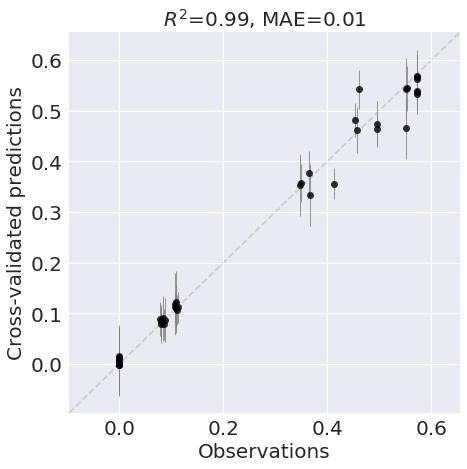

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence 

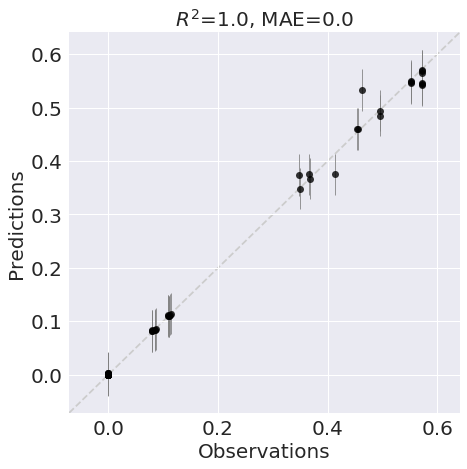

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


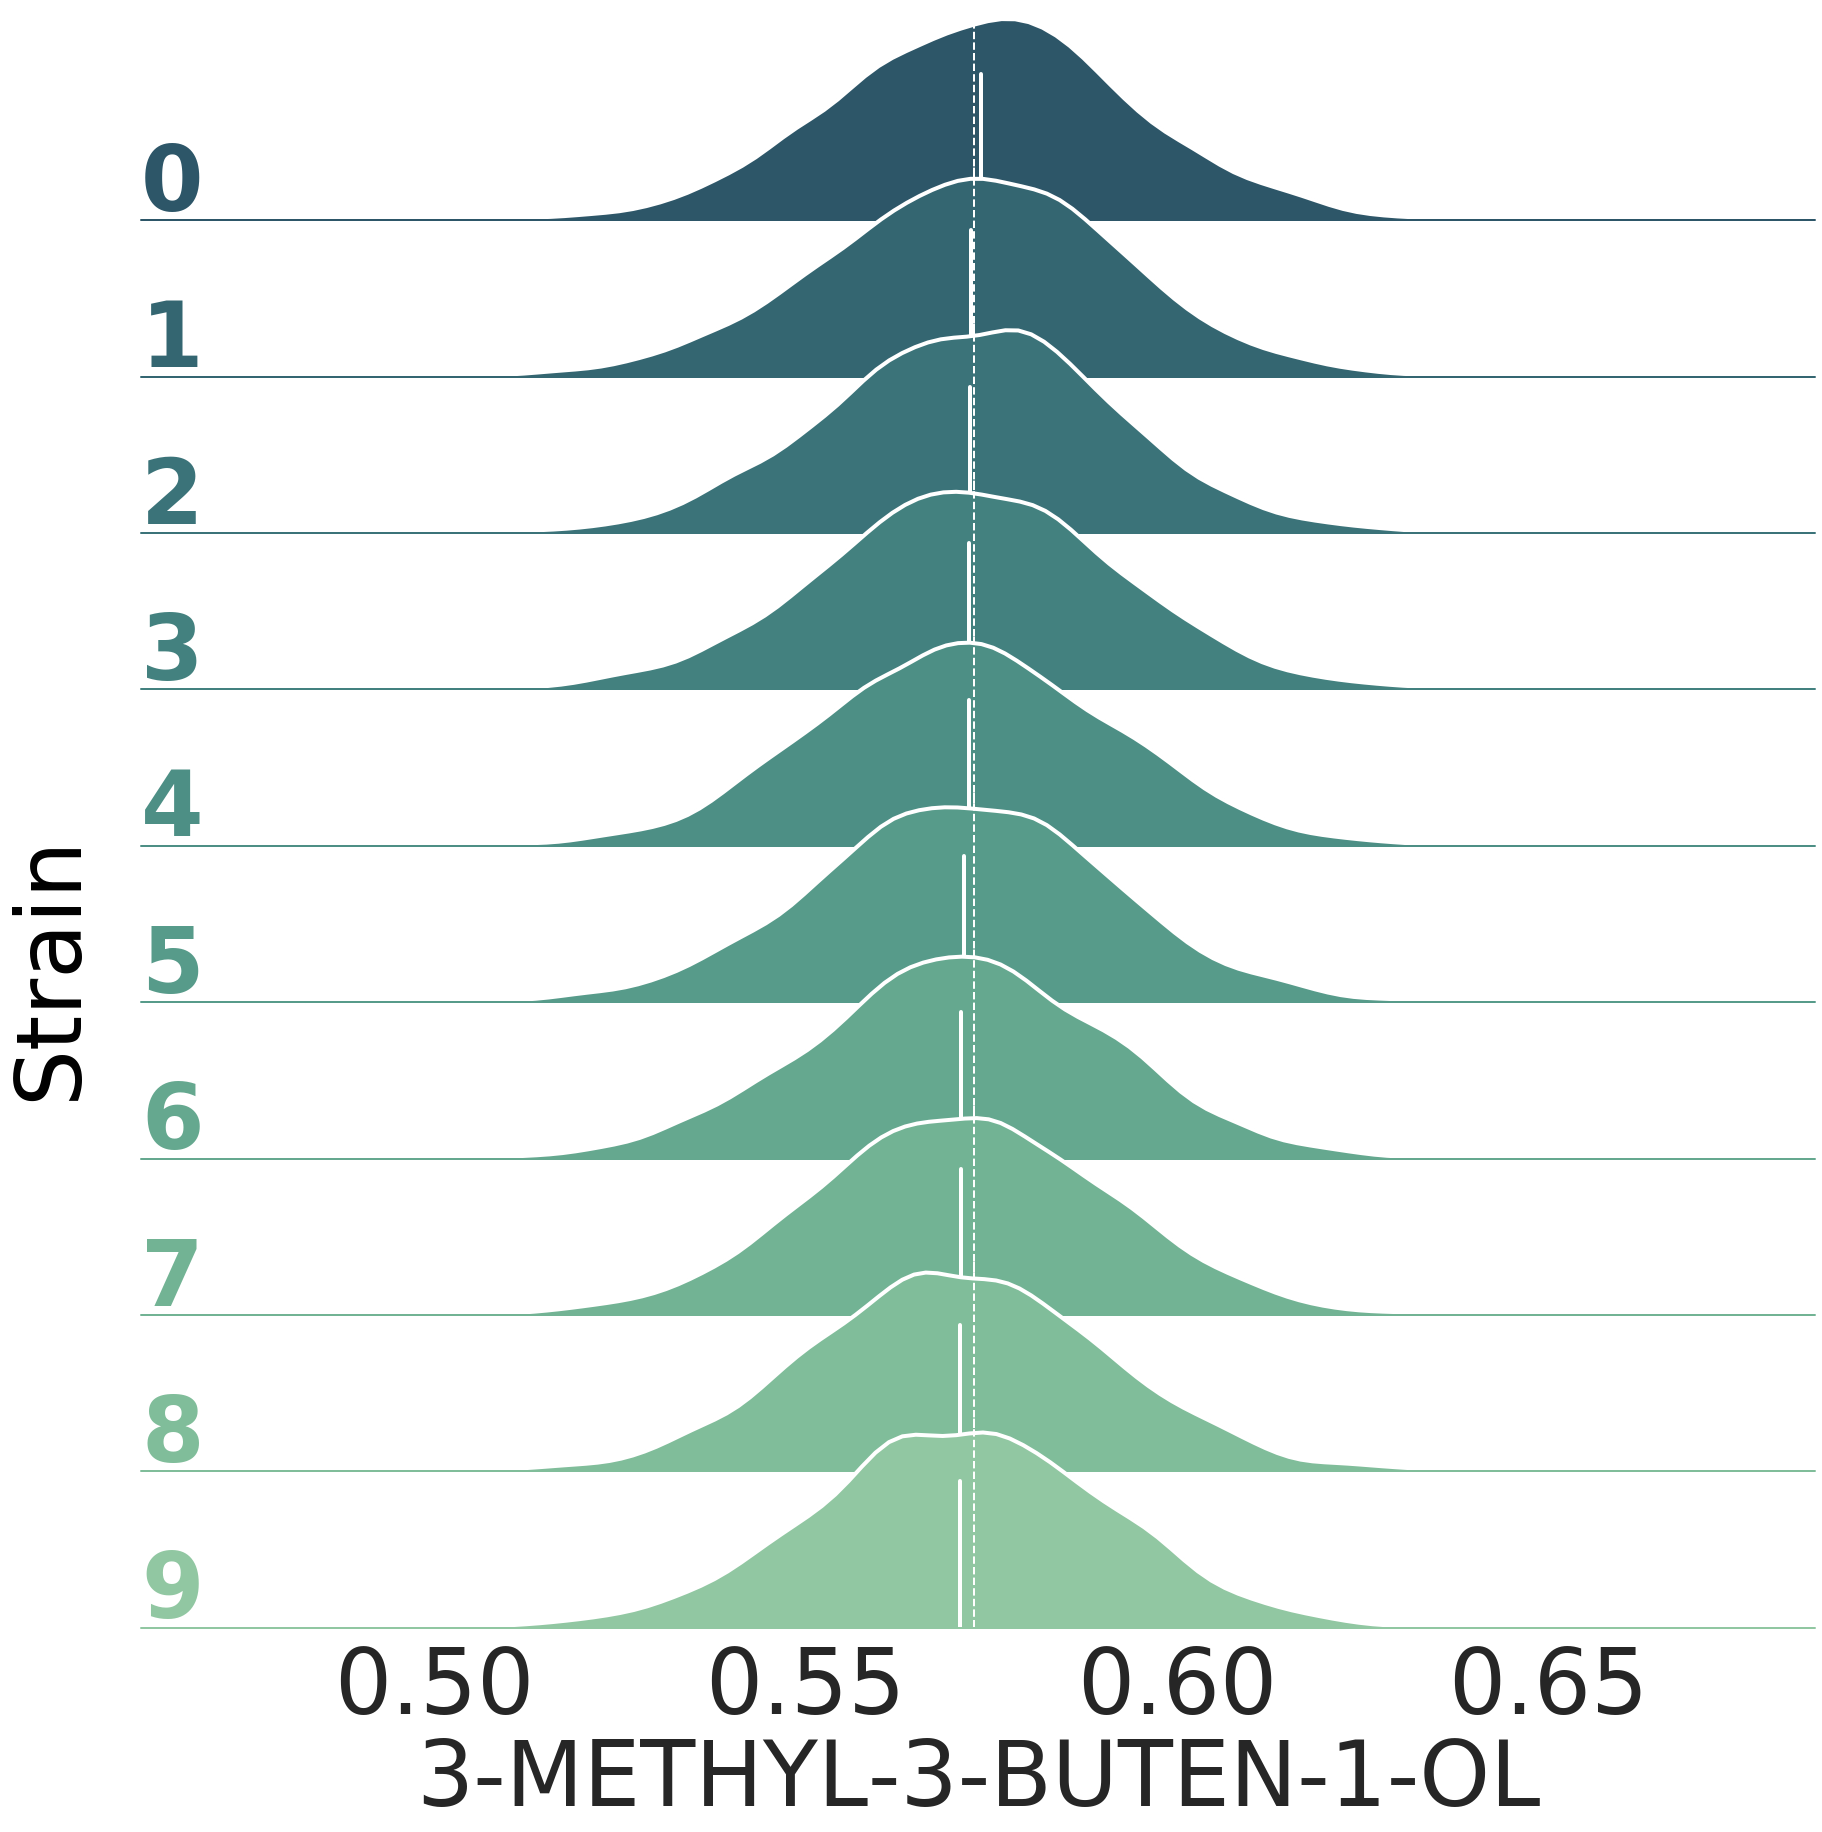

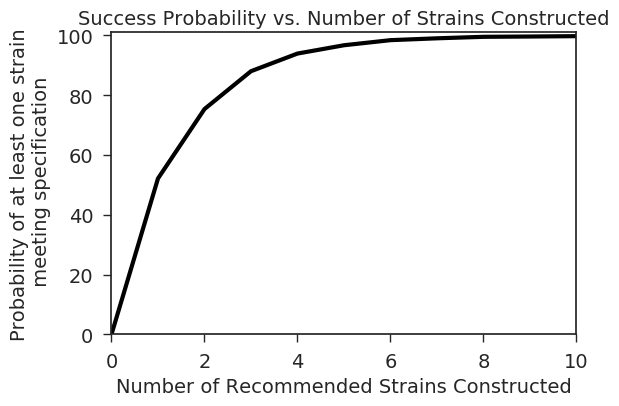

CPU times: user 26min 57s, sys: 12min 14s, total: 39min 12s
Wall time: 22min 48s


In [19]:
%%time
if run_art:
    art = RecommendationEngine(df, **art_params)
else:
    with open(os.path.join(art_params['output_directory'], 'art.pkl'), 'rb') as output:
        art = pickle.load(output)

In [20]:
art.save_pkl_object()


### List the set of design recommendations generated by ART

In [21]:
art.recommendations

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,3-METHYL-3-BUTEN-1-OL
0,2.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.573584
1,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,0.572193
2,1.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.572167
3,2.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,0.572039
4,2.0,2.0,1.0,2.0,2.0,1.0,0.0,1.0,0.571967
5,2.0,2.0,2.0,2.0,2.0,1.0,0.0,1.0,0.571282
6,2.0,2.0,1.0,2.0,2.0,2.0,0.0,2.0,0.570968
7,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.570915
8,1.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,0.570771
9,2.0,1.0,2.0,2.0,2.0,2.0,0.0,1.0,0.570769


It turns out that all recommendations indicate that the CS and ACACT1r reaction fluxes should double and PPCK should be knocked out. 

### Save recommendations into a file

Finally we save the recommendations, along with the predicted production levels. We will compare them with the ground truth provided by OMG in the next notebook. 

First, we change the last column name to indicate it is predicted:

In [23]:
pred_col_name = 'Mean predicted Isoprenol [mM]'
art.recommendations = art.recommendations.rename(columns={art_params['response_vars'][0]: pred_col_name})


Then, we add standard deviation predictions for the recommendations:

In [24]:
pp_rec_mean, pp_rec_std = art.post_pred_stats(art.recommendations.values[:,:-1])
art.recommendations['SD Isoprenol [mM]'] = pp_rec_std.copy()


We assign Line Name to each of the recommendations:

In [25]:
n_instances = len(set(df['Line Name']))
art.recommendations.insert(loc=0, column='Line Name', value=['Strain ' + str(n_instances+i) for i in range(1,art_params['num_recommendations']+1)])
art.recommendations.head()


,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Mean predicted Isoprenol [mM],SD Isoprenol [mM]
0,Strain 97,2.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.573584,0.019785
1,Strain 98,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,0.572193,0.019752
2,Strain 99,1.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.572167,0.019752
3,Strain 100,2.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,0.572039,0.019787
4,Strain 101,2.0,2.0,1.0,2.0,2.0,1.0,0.0,1.0,0.571967,0.019780


And finally save it in a file:

In [26]:
rec_filename = f'{art.outDir}/ARTrecommendations.csv'
art.recommendations.to_csv(rec_filename, header=True, index=False)